In [7]:
from train.models.bisenetv1 import BiSeNet
import torch

import os
import os.path as osp
import argparse
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.image as mpimg

In [3]:

device_num = 0
# args
parse = argparse.ArgumentParser()
parse.add_argument('--dspth', dest='dspth', type=str)
parse.add_argument('--respth', dest='respth', type=str)
parse.add_argument('--cp_path', dest='cp_path', type=str)
args = parse.parse_args()

usage: ipykernel_launcher.py [-h] [--dspth DSPTH] [--respth RESPTH]
                             [--cp_path CP_PATH]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/syeda/.local/share/jupyter/runtime/kernel-v2-31990kFKvkjI4A3XF.json


SystemExit: 2

/home/syeda/miniconda3/envs/bisenetv2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
def vis_parsing_maps(
        im: Image,
        parsing_anno: np.ndarray,
        stride: int,
        save_path: str,
        save_im: bool = False
        ) -> None:
    """
    Visualizes parsing annotations on an image using color mapping and optional saving.

    Args:
        im : The input image.
        parsing_anno : Parsing annotation array containing class labels.
        stride : Scaling factor for resizing the parsing annotation.
        save_path : Path to save the visualization image.
        save_im : Whether to save the visualization image. Default is False.

    Returns:
        None

    This function visualizes parsing annotations on an input image by assigning colors to different
    parts based on provided class labels. The visualization can be optionally saved to a file.
    The parsed image can be displayed or saved depending on the 'save_im' parameter.
    """
    # Colors for all 20 parts
    part_colors = [
        [20, 20, 20], [0, 0, 255], [50, 65, 225],
        [0, 140, 255], [0, 252, 124],
        [167, 108, 188], [66, 71, 147], [170, 255, 0],
        [19, 69, 139], [0, 255, 170],
        [0, 0, 255], [85, 219, 236], [170, 0, 255],
        [0, 85, 255], [0, 170, 255],
        [255, 255, 0], [255, 255, 85], [255, 255, 170],
        [255, 0, 255], [255, 85, 255], [255, 170, 255],
        [0, 255, 255], [85, 255, 255], [170, 255, 255]
    ]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(
        vis_parsing_anno, None, fx=stride, fy=stride,
        interpolation=cv2.INTER_NEAREST
    )
    vis_parsing_anno_color = np.zeros(
        (vis_parsing_anno.shape[0],
         vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = 2

    for pi in range(0, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    vis_im = cv2.addWeighted(
        cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR),
        0.75,
        vis_parsing_anno_color,
        0.5,
        0
    )
    print('Parsing anno shape:', vis_parsing_anno.shape)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] + '.png', vis_parsing_anno*200)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [20]:
def create_hair_mask(seg_mask, hair_label):
  hair_present = False
  for i in np.unique(seg_mask):
      image_array_test = seg_mask.copy()  
      image_array_test_mono = np.where(image_array_test == i,1,0)
      if abs(i - hair_label) < 0.001:
          hair_mask = image_array_test_mono.copy()
          hair_present = True
        #   print('Hair Detected')
          return hair_mask
      

def get_crop_coords(final_combined_hair_mask):

  # Find contours
  contours, _ = cv2.findContours(final_combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find largest contour
  largest_contour = max(contours, key=cv2.contourArea)

  # Calculate centroid
  M = cv2.moments(largest_contour)
  if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])  
      cy = int(M["m01"] / M["m00"])
  else:
      cx, cy = 0, 0

  crop_size = 512

  # Calculate crop coordinates
  x1 = max(0, cx - crop_size//2)
  x2 = min(final_combined_hair_mask.shape[1], cx + crop_size//2)
  y1 = max(0, cy - crop_size//2) 
  y2 = min(final_combined_hair_mask.shape[0], cy + crop_size//2)

  return x1, x2, y1, y2

def get_patches_inference(cropped_img, cropped_mask):

    resized_cropped_mask = cv2.resize(cropped_mask, (512, 512), interpolation = cv2.INTER_NEAREST)
    # resized_cropped_mask_for_filtering = cv2.resize(cropped_mask_for_filtering, (512, 512), interpolation = cv2.INTER_NEAREST)
    resized_cropped_img = cv2.resize(cropped_img, (512, 512), interpolation = cv2.INTER_NEAREST)
    # Get image dimensions
    height, width = resized_cropped_mask.shape

    # Set number of patches
    num_patches = 64

    # Calculate patch size  
    patch_size = int(width / np.sqrt(num_patches))

    # Initialize empty lists
    patches = [] 
    filtered_patches = []
    patch_map_linear = []
    img_patches = []

    idx = 0
    # Loop over image and extract patches  
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):

            patch = resized_cropped_mask[i:i+patch_size, j:j+patch_size]
            # patch_inspect = resized_cropped_mask_for_filtering[i:i+patch_size, j:j+patch_size]
            patch_inspect = patch
            img_patch = resized_cropped_img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            img_patches.append(img_patch)

            unique = np.unique(patch_inspect)

            if len(unique)>1 and 1 in unique:
                num_matches = (patch_inspect==1).sum()
                fraction = num_matches / patch.size
                
                if fraction < 0.8: 
                    filtered_patches.append(patch)  
                    patch_map_linear.append(idx)

            idx += 1

    return img_patches, patches, filtered_patches, patch_map_linear


def combine_patches(patches, patches_per_row, total_patches, patch_map_linear, only_filtered_patches=False):
    # Calculate the number of rows
    num_rows = total_patches // patches_per_row
    
    # Get the dimensions of the first patch
    patch_height, patch_width = patches[0].shape
    
    # Create a new array with the combined dimensions
    combined_width = patch_width * patches_per_row
    combined_height = patch_height * num_rows
    combined_image = np.zeros((combined_height, combined_width), dtype=patches[0].dtype)

    filtered_patches = [patches[i] for i in patch_map_linear]
    
    if only_filtered_patches: 
        # Iterate over the filtered patches and place them into the combined image
        for i, patch in enumerate(filtered_patches):
            idx = patch_map_linear[i]
            row = idx // patches_per_row
            col = idx % patches_per_row
            x = col * patch_width
            y = row * patch_height
            combined_image[y:y+patch_height, x:x+patch_width] = patch
    else:
        # Iterate over the patches and place them into the combined image
        for idx, patch in enumerate(patches):
            row = idx // patches_per_row
            col = idx % patches_per_row
            x = col * patch_width
            y = row * patch_height
            combined_image[y:y+patch_height, x:x+patch_width] = patch
    
    return combined_image

In [21]:

def evaluate(img_dir, mask_dir, output_dir, checkpoint_pth):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        os.makedirs(output_dir + '/output_images')
        os.makedirs(output_dir + '/output_masks')


    n_classes = 2
    net = BiSeNet(n_classes=n_classes, mode='infer')
    net.cuda(device_num)
    net.load_state_dict(torch.load(checkpoint_pth))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        ])
    

    img_file_names = sorted([f for f in os.listdir(img_dir)])
    alpha_file_names = sorted([f for f in os.listdir(mask_dir)])

    img_file_paths = [os.path.join(img_dir, file_name) for file_name in img_file_names]
    mask_file_paths = [os.path.join(mask_dir, file_name) for file_name in alpha_file_names]

    with torch.no_grad():
        
        for idx in range(len(img_file_paths)):
            img = mpimg.imread(img_file_paths[idx])
            image = img  # img.resize((512, 512), Image.BILINEAR)

            

            min_dim = 512  # Minimum dimension we want to scale to
            width, height = image.size

            # Calculate the scale factor
            scale = min_dim / min(width, height)

            # Get the new width and height
            new_width, new_height = int(width * scale), int(height * scale)

            # Resize image maintaining aspect ratio
            image = image.resize((new_width, new_height))

            img = to_tensor(image)
            img = torch.unsqueeze(img, 0)
            img = img.cuda(device_num)

            # out = net({'img': img})['out']
            # parsing = out.squeeze(0).cpu().numpy().argmax(0)

            # out_inter = out.argmax(1)
            out = net({'img': img})['out_single_channel']
            parsing = out.squeeze(0).cpu().numpy()


            print(np.unique(parsing))
            print(osp.join(respth, image_path))

            vis_parsing_maps(
                image,
                parsing,
                stride=1,
                save_im=True,
                save_path=osp.join(respth, image_path)
                )



In [22]:
img_dir = '/home/syeda/VLR_Project/VLR/inference_media/images'
mask_dir = '/home/syeda/VLR_Project/VLR/inference_media/masks'

img_file_names = sorted([f for f in os.listdir(img_dir)])
mask_file_names = sorted([f for f in os.listdir(mask_dir)])

img_file_paths = [os.path.join(img_dir, file_name) for file_name in img_file_names]
mask_file_paths = [os.path.join(mask_dir, file_name) for file_name in mask_file_names]


In [15]:
to_tensor = transforms.Compose([
        transforms.ToTensor(),
        ])

In [23]:
idx = 0
img = mpimg.imread(img_file_paths[idx])
mask = mpimg.imread(mask_file_paths[idx])

hair_mask = create_hair_mask(mask)
x1, x2, y1, y2 = get_crop_coords(hair_mask)
cropped_mask = hair_mask[y1:y2, x1:x2]
cropped_img = img.copy()[y1:y2, x1:x2]
img_patches, patches, filtered_patches, patch_map_linear = get_patches_inference(cropped_img, cropped_mask)


ValueError: max() arg is an empty sequence

In [25]:
import matplotlib.pyplot as plt

In [31]:
import PIL

In [34]:
mask = cv2.imread(mask_file_paths[idx])

In [37]:
mask.shape

(512, 512, 3)

0


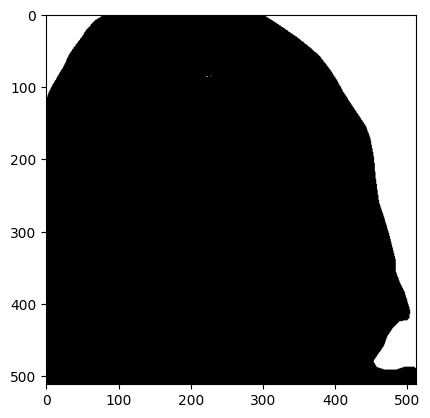

1


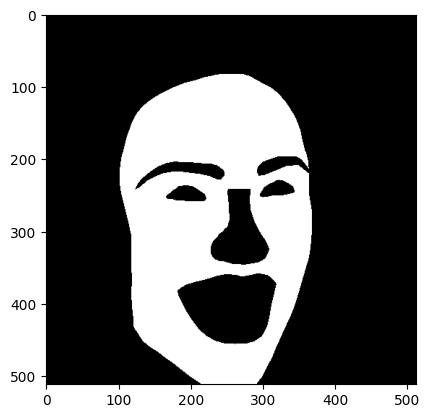

2


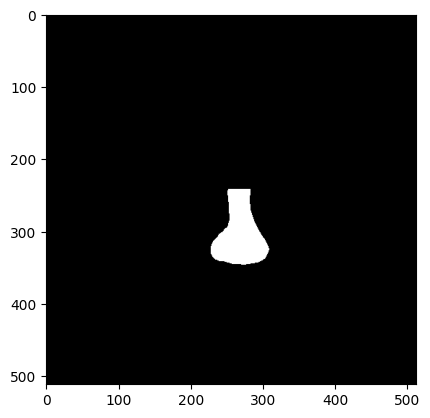

3


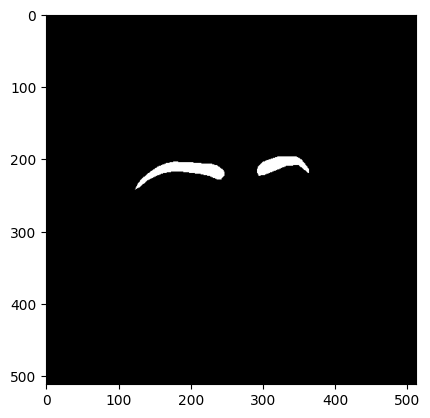

4


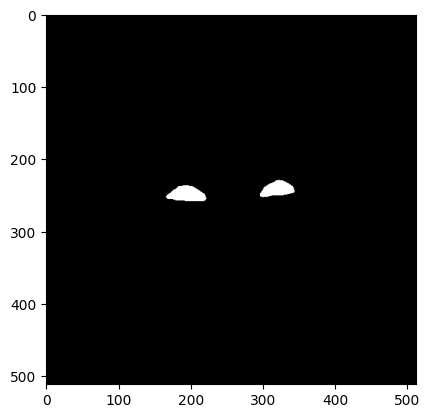

5


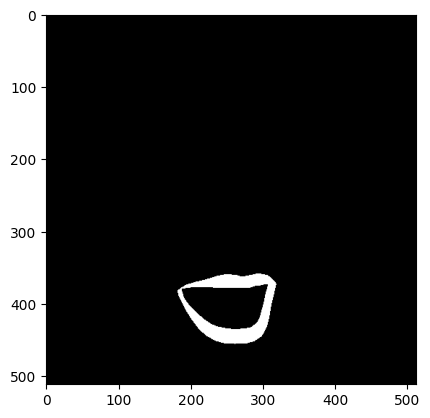

6


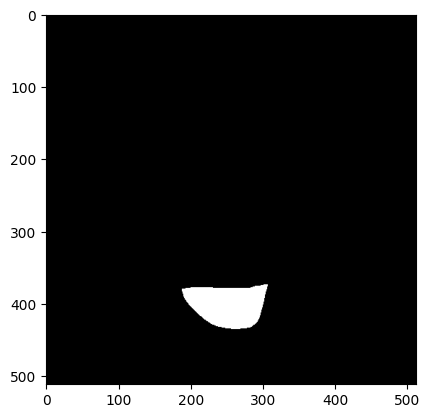

8


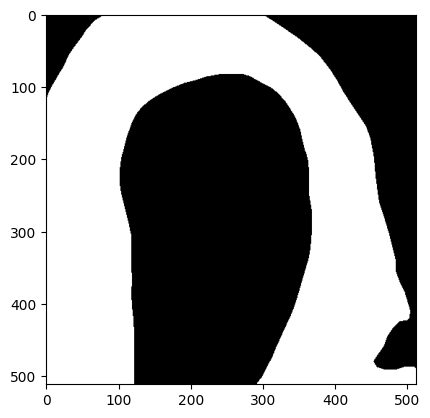

12


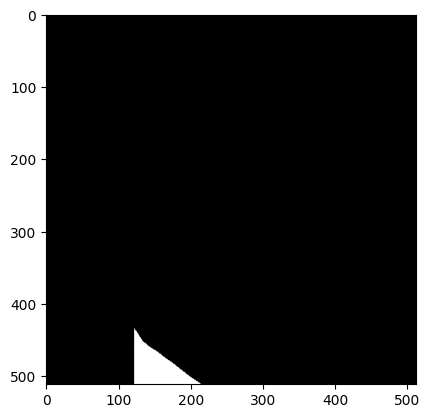

In [36]:
for i in np.unique(mask):
    image_array_test = mask.copy()
    image_array_test_mono = np.where(image_array_test == i,1,0)
    plt.imshow(image_array_test_mono*255)
    print(i)
    plt.show()
    

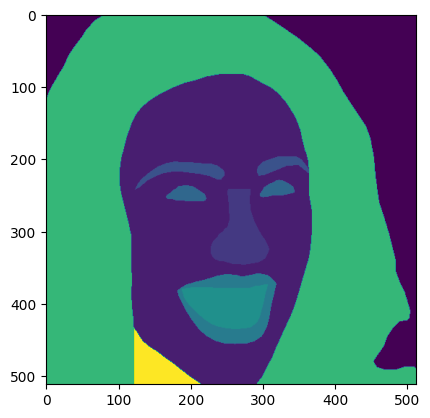

In [27]:
plt.imshow(mask)

In [ ]:
data_dict = dict(
    original_image_size = img.shape,
    seg_mask_size = mask.shape,
    cropped_mask_size = cropped_mask.shape,
    patch_map_linear = patch_map_linear,
    patch_coords = [x1, x2, y1, y2],
    patch_coords_format = 'x1, x2, y1, y2',
)
